# OS13 - Mini projet

Dans le cadre de l'UE OS13, ce notebook est l'étude de durée de vie dans le but de modéliser puis simuler le comportement du système.

## Setup & Découverte des données.

Dans un premier temps, nous allons importer les différentes librairies utilisées pour la suite :

Les librairies pandas et numpy servent à manipuler les tableaux de données, matplotlib à générer les différents graphiques et scipy stats pour toutes les fonctions statistiques utilisées par la suite.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

Avant de chercher à comparer les données, il est important des les observer. Les fonctions *plt.hist* ainsi que *pd.describe* permetttent d'avoir un premier aperçu du jeu de données utilisés.

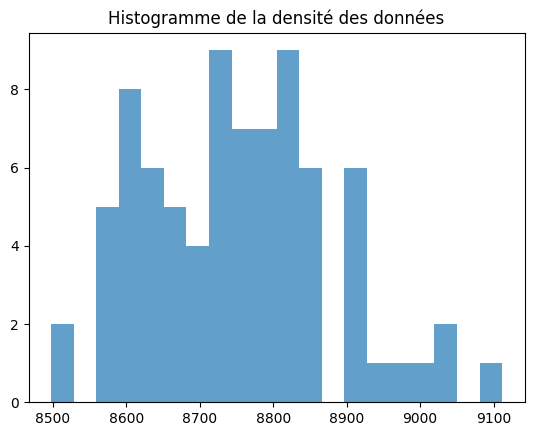

count      80.000000
mean     8751.992509
std       127.830282
min      8497.781998
25%      8648.346542
50%      8746.194650
75%      8825.384389
max      9111.536238
Name: Heures, dtype: float64

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/COURS/OSS/OS13/Part 2/FailureTimes_102.csv",sep=",",names=["index","Heures"],header=0)
nb_data = len(data)

plt.hist(data.Heures,bins=20,label="Données",alpha=0.7,cumulative=False)
plt.title("Histogramme de la densité des données")
plt.show()

data.Heures.describe()

Nous pouvons voir qu'il y a 80 durée de vie sur ce fichier. Ces durées de vie ont pour moyenne 8751, avec des données allant de 8497 à 9111.

De son côté, l'histogramme semble nous montrer une forme "en cloche", typique d'un loi telle que la loi normale par exemple.

# Choix du modèle de durée de vie

La première étape de ce mini-projet est le choix d'un modèle de durée de vie cohérent avec les données. Pour cela, nous allons commencer par des comparaisons graphiques (densité de probabilité, fonction de répartition, QQ plot) puis finir avec un test de Kolmogorov-Smirnov pour trancher entre les différentes lois possibles.

Au vu de l'histogramme vu au dessus, les lois qui vont être testées seront la loi normale, log-normale, gamma et de Weibull.

Une attention est porté au lois de Weibull et Gamma, qui comporte un paramètre "loc" qu'on ne retrouve pas forcément sur leurs expressions usuelles. Ce paramètre correspond la valeur minimum de la loi : elle vaut habituellement 0, d'ou une loi défini sur un semi-infini. Ce paramètre nous permet de s'approcher de nos données mêmes si elles sont centrées sur 8751.

## Estimation des paramètres des lois

Pour la suite, nous avons besoin d'estimer les paramètres de nos lois, pour pouvoir les simuler. La méthode *fit* du module scipy.stats permet d'utiliser 2 méthodes différentes pour l'estimation des paramètres : méthode des moments (MM) et Maximum de Vraisemblance (MLE).
La première estimation est faite en utilisation la méthode du maximum de vraisemblance, qui cherche à minimizer le négatif de la fonction log de la densité de probabilité.
La méthode des moments pourra être utilisé comme comparaison après le choix du modèle, pour l'estimation des paramètres de la suite.



In [ ]:
Lois = ["Normale","Lognormale","Gamma","Weibull"]
X=data.Heures
Norm_est = stats.norm.fit(X,method="mle")
print(("Loi normale : loc = {mean: .2f},scale = {std:.2f}").format(mean=Norm_est[0],std=Norm_est[1]))
logNorm_est = stats.lognorm.fit(X,method="mle")
print(("Loi log-normale : s = {mean: .2f} ,loc = {std:.2f} et scale = {rr:.2f}").format(mean=logNorm_est[0],std=logNorm_est[1],rr=logNorm_est[2]))
Gamma_est = stats.gamma.fit(X,method="mle")
print(("Loi Gamma : a = {mean: .2f} ,loc = {std:.2f} et scale = {rr:.2f}").format(mean=Gamma_est[0],std=Gamma_est[1],rr=Gamma_est[2]))
Weibull_est = stats.weibull_min.fit(X,method="mle")
print(("Loi Weibull : c = {mean: .2f} ,loc = {std:.2f} et scale = {rr:.2f}").format(mean=Weibull_est[0],std=Weibull_est[1],rr=Weibull_est[2]))


Loi normale : loc =  8751.99,scale = 127.03
Loi log-normale : s =  0.17 ,loc = 8021.90 et scale = 719.21
Loi Gamma : a =  13.88 ,loc = 8276.11 et scale = 34.29
Loi Weibull : c =  2.42 ,loc = 8462.78 et scale = 326.07


## Densité de probabilité

En se basant sur l'histogramme et les paramètres estimés, nous allons pouvoir comparer les données réelles avec les densités de probabilités

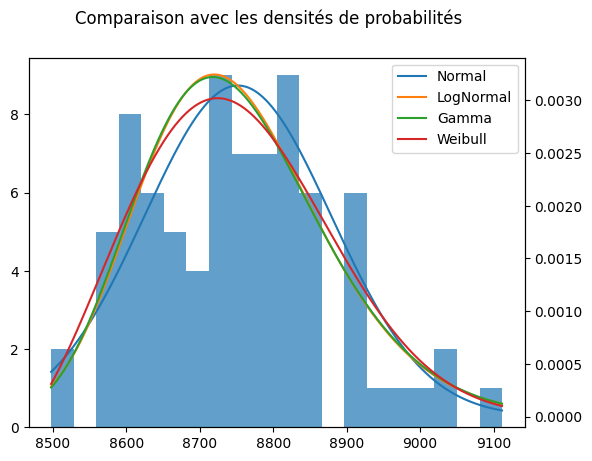

In [ ]:
"""Plot & config"""
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
fig.suptitle("Comparaison avec les densités de probabilités")

"""Histogramme"""
ax1.hist(data.Heures,bins=20,label="Données",alpha=0.7,cumulative=False)

"""Calcul des densités"""
xplot = np.arange(min(X),max(X),0.1)
Y_norm = stats.norm.pdf(xplot, loc =Norm_est[0], scale = Norm_est[1])
Y_lognorm = stats.lognorm.pdf(xplot, logNorm_est[0], logNorm_est[1],logNorm_est[2])
Y_Gamma = stats.gamma.pdf(xplot, Gamma_est[0], Gamma_est[1],Gamma_est[2])
Y_Wei = stats.weibull_min.pdf(xplot, Weibull_est[0], Weibull_est[1],Weibull_est[2])

"""Plot les densités"""
ax2.plot(xplot,Y_norm,label = "Normal")
ax2.plot(xplot,Y_lognorm,label = "LogNormal")
ax2.plot(xplot,Y_Gamma,label = "Gamma")
ax2.plot(xplot,Y_Wei,label = "Weibull")

"""Légendes sur le graphique"""
ax2.legend()

Ces courbes de densités nous permettent de confirmer que l'estimation des paramètres au dessus est correct. Les lois Log-normale et Gamma sont quasiment les mêmes sur la plage d'observation, alors que les 2 autres ont un comportement différents.

## Fonction de répartition

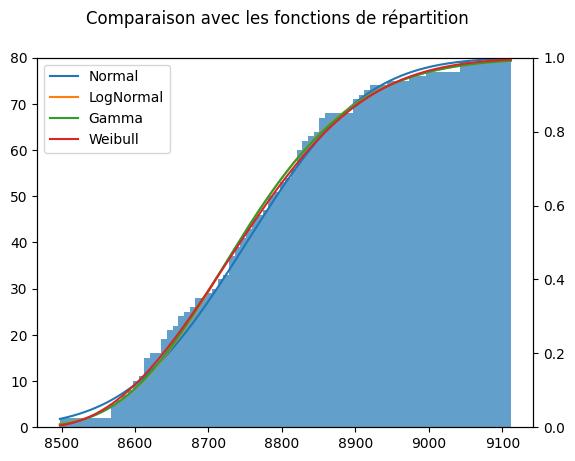

In [ ]:
"""Plot & config"""
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
fig.suptitle("Comparaison avec les fonctions de répartition")

"""Histogramme"""
ax1.hist(data.Heures,bins=80,label="Données",alpha=0.7,cumulative=True)
ax1.set_ylim(0,nb_data)


"""Calcul des densités"""
Y_norm = stats.norm.cdf(xplot, loc =Norm_est[0], scale = Norm_est[1])
Y_lognorm = stats.lognorm.cdf(xplot, logNorm_est[0], logNorm_est[1],logNorm_est[2])
Y_Gamma = stats.gamma.cdf(xplot, Gamma_est[0], Gamma_est[1],Gamma_est[2])
Y_Wei = stats.weibull_min.cdf(xplot, Weibull_est[0], Weibull_est[1],Weibull_est[2])

"""Plot les densités"""
ax2.plot(xplot,Y_norm,label = "Normal")
ax2.plot(xplot,Y_lognorm,label = "LogNormal")
ax2.plot(xplot,Y_Gamma,label = "Gamma")
ax2.plot(xplot,Y_Wei,label = "Weibull")
ax2.set_ylim(0,1)

"""Légendes sur le graphique"""
ax2.legend()

Encore une fois, les 4 lois semblent cohérentes avec les données. Cette fois, la différence visuelle entre les lois est très faible, même si la loi normale s'éloigne un peu des autres.

## Diagramme Quantile-Quantile


Le diagramme quantile-quantile permet de comparer plus précisemment l'écart entre les données et la distribution d'une loi. Sur un diagramme quantile-quantile, il est intéressant de noter 2 choses : le coefficient directeur de la droite obtenue par regression, et le coefficient de corrélation avec cette droite.

Le premier est proche de 1, soit une droite à 45°, lorsque les distributions sont similaires, et le 2e s'approche de 1 lorsque la corrélation est constante sur l'ensemble étudié.

,Directeur,Corrélation
Normale,1.015408,0.990907
Lognormale,1.020145,0.996697
Gamma,1.0181,0.996705
Weibull,1.01418,0.996245


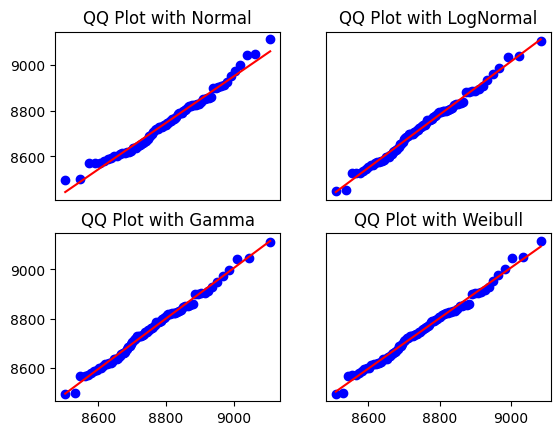

In [ ]:
QQ = pd.DataFrame(index=Lois,columns=["Directeur","Corrélation"])


plt.xlabel=(" ")

"""Normale"""
ax1 = plt.subplot(221)
QQ_norm = stats.probplot(data.Heures, dist="norm",sparams=Norm_est,plot=plt)
QQ.loc['Normale']=(QQ_norm[1][0],QQ_norm[1][2])
plt.title("QQ Plot with Normal")
plt.xticks([])

"""LogNormale"""
ax2 = plt.subplot(222)
QQ_LN = stats.probplot(data.Heures, dist="lognorm",sparams=logNorm_est,plot=plt)
QQ.loc['Lognormale']=(QQ_LN[1][0],QQ_LN[1][2])
plt.title("QQ Plot with LogNormal")
plt.xticks([])
plt.yticks([])
"""Gamma"""
ax3 = plt.subplot(223)
QQ_Gamma = stats.probplot(data.Heures, dist="gamma",sparams = Gamma_est,plot=plt)
QQ.loc['Gamma']=(QQ_Gamma[1][0],QQ_Gamma[1][2])
plt.title("QQ Plot with Gamma")
"""Weibull"""
ax4 = plt.subplot(224)
QQ_Weibull = stats.probplot(data.Heures, dist="weibull_min",sparams = Weibull_est,plot=plt)
QQ.loc['Weibull']=(QQ_Weibull[1][0],QQ_Weibull[1][2])
plt.title("QQ Plot with Weibull")
plt.yticks([])

display(QQ)



Encore une fois, les 4 lois ont des résultats assez similaires, qui sont plutôt bon.

## Kolmogorov-Smirnov Test

Afin de trancher entre ces lois, nous pouvons utiliser le test de Kolmogorov-Smirnov. Ce test nous permet d'évaluer la probabilité qu'un échantillon provienne de la distribution étudiée, ainsi que la distance entre les 2.
Nous obtenons donc 2 valeurs :
* la p-value, permettant d'écarter l'hypothèse "l'échantillon provient de la distribution" si la p-value est inférieur au seuil voulue (couramment défini à 0.5).
* D : la distance entre l'échantillon et la distribution.

La p-value ne permettant que difficilemment d'affirmer une hypothèse, nous nous baserons sur la distance pour faire notre choix.

Nous pouvons observer la différence avec une distribution exponentielle pour confirmer le fonctionnement.

In [ ]:
"""Observation avec une loi exp"""
Exp_est = stats.expon.fit(X,method="mle")
KS_exp = stats.kstest (X,"expon",args=(Exp_est))
display(KS_exp)
"""KS-test"""
KS_norm = stats.kstest (X,"norm",args=(Norm_est))
KS_lognorm = stats.kstest(X,"lognorm",args=(logNorm_est))
KS_gamma = stats.kstest(X,"gamma",args=(Gamma_est))
KS_wei = stats.kstest(X,"weibull_min",args=(Weibull_est))
"""Mise en forme DataFrame"""
KS_bar_pvalue = [KS_norm[1],KS_lognorm[1],KS_gamma[1],KS_wei[1]]
KS_bar_D = [KS_norm[0],KS_lognorm[0],KS_gamma[0],KS_wei[0]]
KS_res = pd.DataFrame(KS_bar_pvalue,columns=["P-value"],index=Lois)
KS_res["D"]=KS_bar_D
KS_res

KstestResult(statistic=0.23590754173257927, pvalue=0.0002119802033682303, statistic_location=8616.61497300508, statistic_sign=-1)

,P-value,D
Normale,0.927564,0.059034
Lognormale,0.971231,0.052636
Gamma,0.980301,0.050573
Weibull,0.979824,0.050696


Dans le cas de la loi exponentielle, avec une p-value inférieur à 0.005, nous pouvons confirmer que ce n'est pas une distribution possible pour l'estimation.

Pour les autres, toutes les p-value sont supérieures à 0.90, on peut les supposer cohérentes avec les données.

Pour faire le choix, nous regardons D, la distance, qui est la minimum pour la loi Gamma, avec 0.050573.

# Estimation du modèle choisi

Avant la simulation, il est important de confirmer les paramètre estimés pour la loi Gamma, ainsi que de regarder son espérance et sa variance. L'espérance sera par exemple utile pour estimer la loi de réparation par la suite.

## Estimation des paramètres

Après le choix du modèle, nous pouvons revenir sur les paramètres que nous utiliserons par la suite pour la loi Gamma. Pour cela, comme évoqué auparavant nous utiliserons la méthode des moments ainsi que la méthode du maximum de vraisemblance pour comparer.

In [ ]:
EST = pd.DataFrame(columns = ["a","location","scale","D","p-value"])
"""Maximum de vraisemblance"""
MLE_Est = stats.gamma.fit(X,method="mle")
KS_MLE = stats.kstest(X,"gamma",args=(MLE_Est))
EST.loc["MLE",["a","location","scale"]]=MLE_Est
EST.loc["MLE",["D","p-value"]]=KS_MLE[0:2]
"""Méthode des moments"""
MM_Est = stats.gamma.fit(X,method="mm")
KS_MM = stats.kstest(X,"gamma",args=(MM_Est))
EST.loc["MM",["a","location","scale"]]=MM_Est
EST.loc["MM",["D","p-value"]]=KS_MM[0:2]

display(EST)

min_meth = np.argmin(EST["D"])
Model_EST = EST.iloc[min_meth].loc["a":"scale"]
display(Model_EST)

,a,location,scale,D,p-value
MLE,13.879928,8276.113744,34.285393,0.050573,0.980301
MM,23.019533,8142.525007,26.476102,0.052,0.974272


a             13.879928
location    8276.113744
scale         34.285393
Name: MLE, dtype: object

On se base sur la valeur de D pour confirmer la méthode d'estimation. Ici, D est le minimum pour la méthode de Maximum de Vraisemblance (Maximum Likelihood Estimation).

La fonction Gamma est habituellement estimé par 2 paramètres, et se calcule sous cette forme :     
$ f(x,α,β )=
\frac{β ^α x^{α-1} e^{-βx}}
{Γ (α)}$
avec $α$ le paramètre de forme et 1/β le paramètre d'échelle.

Pour la simulation sur python, un paramètre de plus est estimé : loc, qui s'ajoute à la fonction pour effectuer un "décalage" sur l'axe x.

Nous avons donc 3 paramètres estimés :
* a : paramètre de forme
* loc : le décalage par rapport à 0
* scale : 1/β, le paramètre d'échelle


Nous pouvons observer que l'ensemble solution optimale ici vaut (13,88 ; 8276,11 ; 34,28).

Ces 3 paramètres sont stockés dans la série Model_EST

## Esperance et Variance

Dans cette partie, nous pouvons observer l'espérance et la variance d'un point de vue théorique ou par résolution par méthode, ainsi qu'une comparaison avec la moyenne et la variance d'origine des données.

L'espérance de la loi Gamma est égale à $μ = \frac{α}{β}   $    
Sa variance vaut $σ^2 = \frac{α}{β^2}   $

Notre fonction utilise un 3e paramètre, loc (ici location). Pour obtenir l'espérance de la loi gamma, il faut ajouter loc à l'espérance. Le paramètre loc étant un décalage, il ne change rien à la variance.


In [ ]:
"""Approche Théorique"""
beta = 1/Model_EST.scale
alpha = Model_EST.a
E_th = alpha/beta + Model_EST.location
V_th = alpha/(beta**2)
print("----Approche théorique----")
print("Espérance :",E_th)
print("Variance :",V_th)

"""Calcul Esperance et Variance"""
E_model = stats.gamma.mean(a=Model_EST.a , loc=Model_EST.location,scale=Model_EST.scale)
V_model = stats.gamma.var(a=Model_EST.a , loc=Model_EST.location,scale=Model_EST.scale)
print("----Méthode calculatoire----")
print("Espérance :",E_model)
print("Variance :",V_model)

"""Comparaison loi normale des données"""
print("----Comparaison avec la loi normale----")
print("Moyenne d'origine : ",X.describe()[1])
print("Ecart type d'origine : ",X.describe()[2])
print("Variance d'origine : ",X.describe()[2]**2)


----Approche théorique----
Espérance : 8751.992513048062
Variance : 16315.690567669153
----Méthode calculatoire----
Espérance : 8751.992513048062
Variance : 16315.690567669151
----Comparaison avec la loi normale----
Moyenne d'origine :  8751.992509273254
Ecart type d'origine :  127.83028160573976
Variance d'origine :  16340.580895402727


La résolution par paramètre et en calculant sur l'ensemble des données nous permet d'obtenir le même résultat : $E[X] = 8751,99$ et $Var[X] = 16315,69$.

En comparant avec la première estimation d'une loi normale que nous avions dès le début utilisant *pd.describe*, cela nous semble cohérent pour utiliser les valeurs par la suite.

# Simulation du modèle

## Estimation des paramètres de la réparation :

Pour estimer la loi de réparation, il est demandé d'estimer le paramètre d'une loi exponentielle tel que le MTTR représente environ 20% du MTTF (ici appelé *Ratio_MTT* ce pourcentage).

Le MTTF correspond à l'espérance de la loi de panne, calculée plus haut. Il vaut ici environ 8751.

Une loi exponentielle est défini par la fonction $f(x)=λ e^{- λ x}$, avec $λ$ comme unique paramètre. La version scipy.stats de cette loi demande comme paramètre scale, qui équivaut $\frac{1}{λ}$.

L'espérance d'une loi exponentielle, équivalent ici à notre MTTR, vaut $E[X] = \frac{1}{λ}$. On trouve donc $scale = E[X_{reparation}]$. Nous posons donc $scale =E_{model}*20\%$.

In [ ]:
Ratio_MTT = 20/100
E_repa = E_model*Ratio_MTT
MTTR = stats.expon.mean( loc =0, scale = E_repa)
print(MTTR)

1750.3985026096125


## Simulation Monte Carlo : un seul produit

La simulation Monte Carlo consiste à simuler des tirages aléatoire pour estimer l'espérance d'une variable aléatoire. L'objectif ici est d'estimer la disponibilité asymptotique en fonction de nos lois de panne et de réparation.

Pour évaluer la performance, nous pouvons calculer la disponibilité asymptotique théorique : $A_{th} = \frac{MTTF}{MTTF + MTTR}=\frac{MTTF}{MTTF + Ratio\_MTT * MTTF}=\frac{MTTF}{MTTF(1+Ratio\_MTT)}=\frac{1}{1+Ratio\_MTT}$.

En applicant numériquement : $A_{th}=\frac{1}{1.2} = 0.83...$

Pour effectuer la simulation sur un seul produit, nous allons effectuer un nombre de cycle avec un tirage de panne puis de réparation mis bout à bout. L'estimation de la disponibilité se fait en divisant le temps de bon fonctionnement par le temps total.


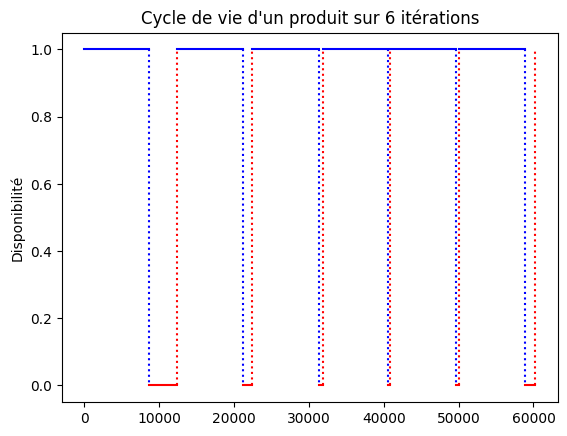

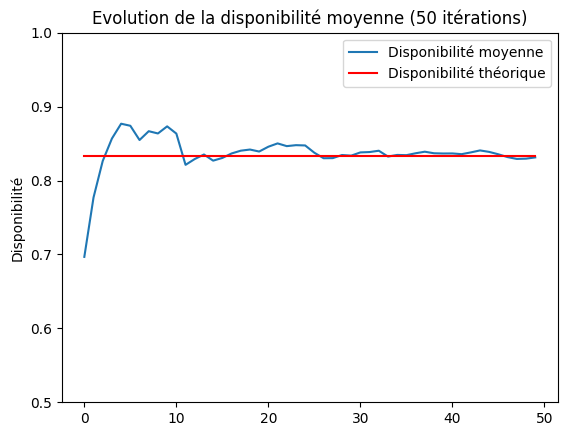

In [ ]:
"""Fonction du tirage des 2 lois"""
def tirage():
  T1 = stats.gamma.rvs(a=Model_EST.a , loc=Model_EST.location,scale=Model_EST.scale)
  T2 = stats.expon.rvs(scale = E_repa)
  return T1,T2
"""Initialisation des variables"""
np.random.seed(seed=233423) #Permet de fixer un aléatoire pour commenter et expliquer le même visuel
t=0
Tot_marche = 0
A=[]
Dispo_th = 1/(Ratio_MTT+1)
"""Paramètres des plots"""
it = 50 #itérations pour l'estimation
cy = 6 #nombre de cycle visible sur le premier plot

"""Simulation"""
for i in range(it):
  T_panne,T_repair = tirage()
  Tot_marche += T_panne
  if i<cy :
    plt.plot([t,t+T_panne],[1,1],c="blue",label="Marche")
    plt.plot([t+T_panne,t+T_panne],[1,0],linestyle=":",c="blue")
  t=t+T_panne
  if i<cy :
    plt.plot([t,t+T_repair],[0,0],c="red",label="Panne")
    plt.plot([t+T_repair,t+T_repair],[0,1],linestyle=":",c="red")
  t=t+T_repair
  A.append(Tot_marche/t)
plt.ylabel("Disponibilité")
plt.title("Cycle de vie d'un produit sur "+str(cy)+" itérations")
plt.show()

"""Plot évolution de la disponibilité moyenne sur un produit"""
plt.plot(A,label="Disponibilité moyenne")
plt.plot([0,it-1],[Dispo_th,Dispo_th],label="Disponibilité théorique",c="red")
plt.ylim(0.5,1)
plt.legend()
plt.ylabel("Disponibilité")
plt.title("Evolution de la disponibilité moyenne ("+str(it)+" itérations)")
plt.show()


Sur la première figure, nous pouvons voir en bleu les périodes de bon fonctionnement et en rouge les périodes de pannes. Les périodes en rouge ont une variance assez forte par rapport à celles en bleu, qui est cohérente avec les paramètres.
Si on élargit avec plus de cycle, nous pouvons retrouver l'évolution moyenne de la disponibilité en accord avec ces cycles. Pour permettre de représenter la disponibilité, c'est la moyenne depuis l'origine qui est indiqué. C'est à dire que la courbe au point 5 correspond à la disponibilité moyenne entre les cycles 1 à 5.

Lors du premier cycle, un temps de panne important entraine une disponibilité plus basse, autour de 0.7. Ensuite, des cycles avec un faible temps de panne font monter la disponibilité jusqu'à 0.87 , avant de se stabiliser autour du 0.83 qui correspond à la théorie.

## Simulation Monte Carlo : multiple produits

Pour compléter la simulation à un produit, le faire avec plusieurs produits est intéressant. Cela nous permet d'avoir la disponibilité en temps réelle, qui correspond au pourcentage de produit encore en fonctionnement.

In [ ]:
n = 1000
it = 20
T = np.full((n*it*2,3),0)
a=0
for i in range(n):

  t=0
  for k in range(it):
    T_panne,T_repair = tirage()
    t=t+T_panne
    T[a,0]=t
    T[a,1]=1
    t=t+T_repair
    a+=1
    T[a,0]=t
    T[a,1]=0
    a+=1
  T[a-1,1]=2

 Ce premier ensemble de code génère les tirages (it) pour chaque produit (n). La matrice T stocke l'ensemble des temps de panne et de réparation, ainsi que si c'est l'un ou l'autre. La 3e colonne est utilisé par la suite pour stocker le nombre de produit en fonctionnement au cours du temps.

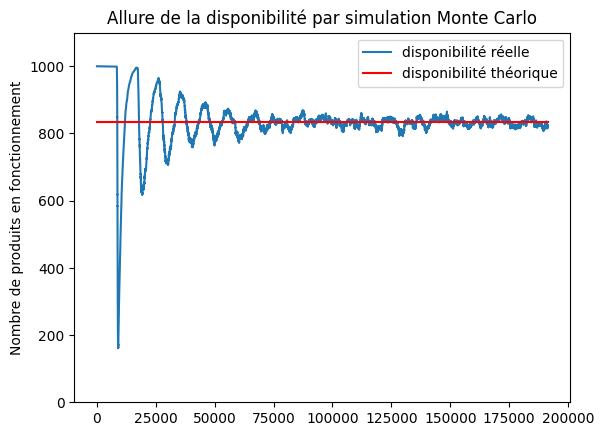

,0,1,2
35621,191408,1,823
35622,191409,0,824
35623,191410,1,823
35624,191411,0,824
35625,191411,0,825
35626,191414,1,824
35627,191417,1,823
35628,191418,1,822
35629,191421,1,821
35630,191428,1,820


In [ ]:
#B est la matrice T triée
B = T[T[:, 0].argsort()]
B = np.insert(B,[0],[0,0,n],axis=0)
#Mets à jour la 3e colonne avec le nombre de produits en fonctionnement
for i in range(1,len(B)):
  if B[i,1]==1:
    B[i][2]=B[i-1][2]-1
  elif B[i,1]==0:
    B[i][2]=B[i-1][2]+1
  else :
    end=i #Pour ne pas prendre en compte une fois qu'on est arrivé à la fin d'un produit
    break


plt.plot(B[:end,0],B[:end,2],label = "disponibilité réelle")
plt.plot([0,max(B[:end,0])],[Dispo_th*n,Dispo_th*n],label="disponibilité théorique",c="red")
plt.ylim(0,1100)
plt.legend()
plt.ylabel("Nombre de produits en fonctionnement")
plt.title("Allure de la disponibilité par simulation Monte Carlo")
plt.show()

C = pd.DataFrame(B)
C[:end].tail(10)

Lors du premier cycle, nous pouvous observer que quasiment tous les produits tombent en panne avant que les premières réparations interviennent pour revenir quasiment à tous les produits en marche. Ensuite, la variance des 2 lois vont décaler petit à petit chaque produites, jusqu'à ne plus reconnaitre les cycle sur la fin.
Au bout de 8 cycles, nous sommes quasiment arrivées à un état stationnaire, avec environ 830 produits en marche. Sur les 10 derniers temps, il y a entre 831 et 834 produits en marche.

# Politique de maintenance

Pour compléter l'approche de modélisation et de simulation, nous allons voir l'impact d'une politique de maintenance basé sur l'age sur notre système. L'idée est de définir $t_0$ tel qu'une maintenance est effectuée à $t_0$ si la panne n'est pas arrivée avant cela.

Cette simulation se fait sous l'observation du cout moyen par unité de temps, qui dépend donc des couts :
* Cout de panne (c_panne) : le cout d'une maintenance réparative
* Cout de maintenance (c_maint) : le cout d'une maintenance prédictive

Pour effectuer la simulation, nous allons reprendre la fonction tirage utilisée auparavant.

### Paramètres propres à la maintenance

Pour définir notre politique de maintenance, nous définissons ici les différents paramètres pour la mettre en place.

In [ ]:
"""Paramètre propre à la maintenance"""
c_panne = 10000
c_maint = 6000

### Mise en fonction

Pour simplifier la suite, les fonctions utiles sont définis ici

In [ ]:
def tirage():
  T1 = stats.gamma.rvs(a=Model_EST.a , loc=Model_EST.location,scale=Model_EST.scale)
  T2 = stats.expon.rvs(scale = E_repa)
  return T1,T2

In [ ]:
def MC_simple(n=1,it=4,plot = False):
  T = np.full((n*it*2,3),0)
  a=0
  for i in range(n):
    t=0
    for k in range(it):
      T_panne,T_repair = tirage()
      t=t+T_panne
      T[a,0]=t
      T[a,1]=1
      t=t+T_repair
      a+=1
      T[a,0]=t
      T[a,1]=0
      a+=1
    T[a-1,1]=2
  B = T[T[:, 0].argsort()]
  B = np.insert(B,[0],[0,0,n],axis=0)
  for i in range(1,len(B)):
    if B[i,1]==1:
      B[i][2]=B[i-1][2]-1
    elif B[i,1]==0:
      B[i][2]=B[i-1][2]+1
    else :
      end=i #Pour ne pas prendre en compte une fois qu'on est arrivé à la fin d'un produit
      break
  if plot :
    Plot_simple(B,end,n)
  return pd.DataFrame(B)

def Plot_simple(B,end,n):
  plt.plot(B[:end,0],B[:end,2],label = "disponibilité réelle")
  plt.plot([0,max(B[:end,0])],[Dispo_th*n,Dispo_th*n],label="disponibilité théorique",c="red")
  plt.ylim(0,n*1.1)
  plt.legend()
  plt.ylabel("Nombre de produits en fonctionnement")
  plt.title("Allure de la disponibilité par simulation Monte Carlo")

## Maintenance sur un seul produit

Pour simuler la politique de maintenance, il suffit de comparer $t_0$ avec le temps de panne obtenue. Si $t_0$ est inférieur, une maintenance prédictive est mise en place et on tire un nouveaux temps de panne. Sinon, on applique juste le temps de panne d'origine.
Nous prenons $t_0 = E_{model}$ pour avoir environ moitié des temps de panne en dessous de $t_0$.


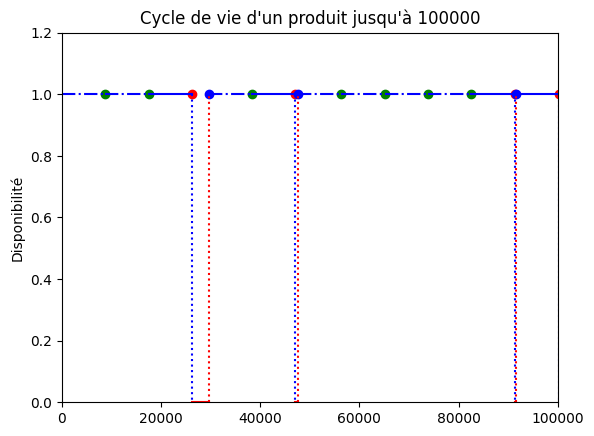

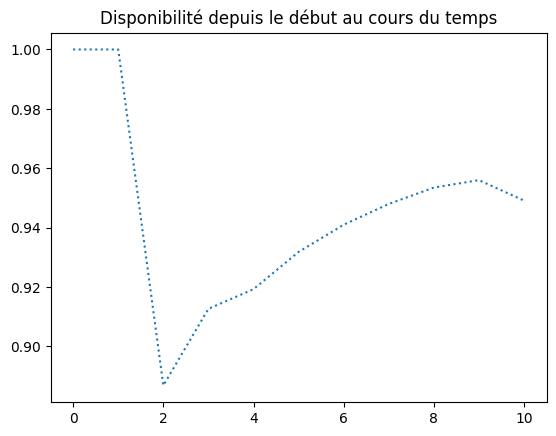

In [ ]:
"""Initialisation des variables"""
np.random.seed(seed=233429) #Permet de fixer un aléatoire pour commenter et expliquer le même visuel
t=0
Tot_marche = 0
A=[]
Dispo_th = 1/(Ratio_MTT+1)
"""Paramètres des plots"""
it = 5 #itérations pour l'estimation
horizon = 100000
cy = 5 #nombre de cycle visible sur le premier plot
t0 = E_model

"""Simulation"""
while t<horizon:
  T_panne,T_repair = tirage()
  while (t0<T_panne and t<horizon):
    plt.plot([t,t+t0],[1,1],c="blue",linestyle="dashdot",label="Marche")
    plt.scatter(t+t0,1,c="green")
    t=t+t0
    Tot_marche += t0
    A.append(Tot_marche/t)
    T_panne,T_repair=tirage()
  Tot_marche += T_panne
  plt.scatter(t+T_panne,1,c="red")
  plt.plot([t,t+T_panne],[1,1],c="blue",label="Marche")
  plt.plot([t+T_panne,t+T_panne],[1,0],linestyle=":",c="blue")
  t=t+T_panne
  plt.scatter(t+T_repair,1,c="blue")
  plt.plot([t,t+T_repair],[0,0],c="red",label="Panne")
  plt.plot([t+T_repair,t+T_repair],[0,1],linestyle=":",c="red")
  t=t+T_repair
  A.append(Tot_marche/t)
plt.ylabel("Disponibilité")
plt.title("Cycle de vie d'un produit jusqu'à "+str(horizon))
plt.ylim(0,1.2)
plt.xlim(0,horizon)

plt.show()

plt.title("Disponibilité depuis le début au cours du temps")
plt.plot(A,":")
plt.show()

Nous pouvons voir que 7 maintenances prédictives ont été effectués sur cette simulation (les 7 points en vert). La maintenance prédictive permet d'avoir une disponibilité bien plus forte que ce qui était observé auparavant, ne descendant ici pas bien en dessous de 0.90 avant de remonter.

Il est intéressant de noter que cette méthode suppose une réparation à neuf, entrainant possiblement des durée de vie cumulée très importante (comme ici entre 50 000 et 90 000).

## Maintenance multi-produit

Nous avons vu au dessus comment appliquer une politique de maintenance sur un seul produit. La difficulté est maintenant de généraliser cette méthode avec plusieurs produits tout en suivant les effets de la maintenance.

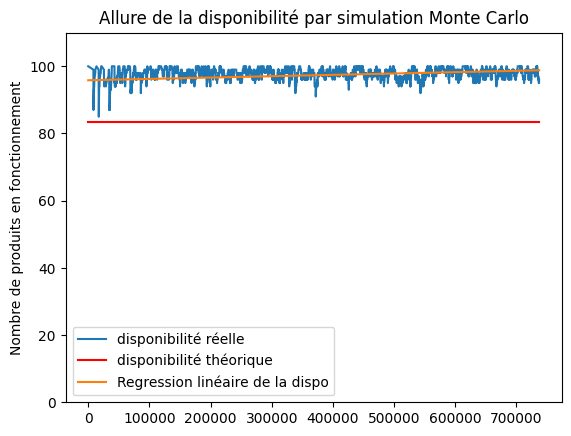

nb maint :  9078


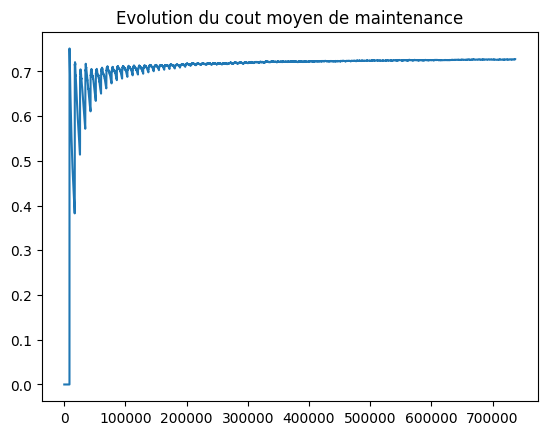

In [ ]:
"""MC_Maintenance"""
def MC_maint(n=1,it=4,t0=E_model,plot = False,c_panne = 10000,c_maint = 6000 ):
  T = np.full((n*it*2*10,5),0.)
  nb_maint = 0
  a=0 #Nombre d'itérations
  """Autre méthode de simulation"""
  for i in range(n):
    t=0
    while a-(i*n)<it*n:
      T_panne,T_repair = tirage()
      """En cas de maintenance prédictive"""
      while (t0<T_panne and a-(i*n)<it*n):
        nb_maint+=1
        t=t+t0
        T[a,0]=t
        T[a,1]=2
        T[a,3]=c_maint
        a+=1
        T_panne,T_repair=tirage()
      t=t+T_panne
      T[a,0]=t
      T[a,1]=1
      T[a,3]=c_panne
      t=t+T_repair
      a+=1
      T[a,0]=t
      T[a,1]=0
      T[a,3]=0
      a+=1
    T[a-1,1]=3
  """Trier dans l'ordre de temps"""
  B = T[T[:, 0].argsort()]
  B = B[B[:,0]>0]
  B = np.insert(B,[0],[0,0,n,0,0],axis=0)
  """Compter le nombre de produit en fonctionnement"""
  for i in range(1,len(B)):
    B[i][4]=(sum(B[:i,3])/B[i][0])/n
    if B[i,1]==1:
      B[i][2]=B[i-1][2]-1
    elif B[i,1]==0:
      B[i][2]=B[i-1][2]+1
    elif B[i,1]==2:
      B[i][2]=B[i-1][2]
    else :
      end=i #Pour ne pas prendre en compte une fois qu'on est arrivé à la fin d'un produit
      break
  """Filter B par la fin de la boucle"""
  B = B[:end,:]
  if plot :
    Plot_simple(B,end,n)
  return pd.DataFrame(B,columns=["t","Etat","Nb","cout","cout_moyen"]),nb_maint

Tab,nb = MC_maint(100,15,t0=8600,plot=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(Tab.t, Tab.Nb)
plt.plot([0,max(Tab.t)],[intercept,intercept + slope*max(Tab.t)],label="Regression linéaire de la dispo")
plt.legend()
plt.show()

plt.title("Evolution du cout moyen de maintenance")
plt.plot(Tab.t, Tab.cout_moyen)
print("nb maint : ",nb)

La fonction mc_maint simule la disponibilité de 100 produits par une simulation de Monte Carlo croisée à une politique de maintenance. Nous obtenons un pandas DataFrame nommé Tab qui stock le temps, l'état du produit concerné à l'instant, le nombre de produits en marche ainsi que le cout associé et le cout moyen. De cela, nous pouvons comparer avec la première partie de ce projet.

En prenant $t_0 = 8600$, assez proche de l'espérance du modèle, nous pouvons voir que cela améliore vraiment les performances par rapport à avant. Nous tournons autour de 92% de disponibilité asymptotique, pour 9130 maintenances prédictives.

A côté de cela, nous pouvons observer l'évolution du cout moyen. Nous pouvons voir qu'il augmente fortement à la première maintenance qui arrive, pour finalement se stabiliser autour de 0.70€ par unité de temps. Pour donner un ordre de grandeur, s'il n'y a jamais de panne, nous avons un $cout = \frac{C_{maint}}{t_0} = \frac{6000}{8600} = 0€69  $. Avec un $t_0$ en dessous de l'espérance et une variance relativement faible, c'est quasiment dans ce cas que nous sommes ici.

## Valeur optimale de $t_0$

Pour trouver la valeur optimale de $t_0$, nous allons pouvoir varier sa valeur et voir l'évolution du cout moyen que nous obtenons. Nous utilisons la fonction définie au dessus, ce qui n'est pas optimale pour le temps de calcul étant donné que nous calculons le tout alors que nous utilisons seulement le cout moyen.

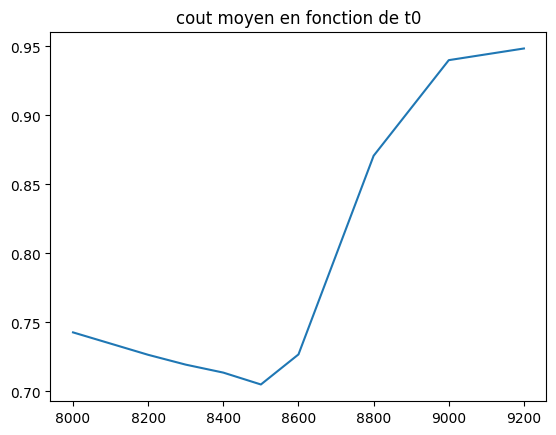

In [ ]:
vals = [8000,8200,8300,8400,8500,8600,8800,9000,9200]
cout_l = []
for val in vals :
  Tab,nb = MC_maint(100,15,t0=val)
  cout_l.append(Tab.cout_moyen.iloc[-1])

plt.title("cout moyen en fonction de t0")
plt.plot(vals,cout_l)


Nous pouvons voir que le cout moyen optimale se trouve ici autour de 8500, et tend vers 0.70. Ce cout optimal dépend bien évidemment de l'ensemble des paramètres estimées auparavant, ainsi que les différentes couts indiqués.

Le cout optimale en fonction de $t_0$ est l'équilibre entre un $t_0 $ asssez bas qui maximise le nombre de maintenance prédictive mais sans trop augmenter le cout moyen défini par $\frac{c_{maint}}{t_0}$